In [ ]:
# Copyright 2024 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.sandbox.google.com/github/https-deeplearning-ai/sc-gc-c4-gemini-public/blob/main/lesson-2/L2_colab_prompting_and_parameters.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

# Cost Estimate

The estimated cost for running this notebook once using your Google Cloud account, without the video segment (which has been converted to markdown), should be less than 0.10 USD (as of August 2024). Get the latest Gemini costs [here](https://cloud.google.com/vertex-ai/generative-ai/pricing).


# SETUP

This is follow up to the [How to Set Up your Google Cloud Account](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/9/how-to-set-up-your-google-cloud-account-|-try-it-out-yourself-[optional]) instructions from the course, [Large Multimodal Model Prompting with Gemini](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/1/introduction) on the [Learning Platform](https://learn.deeplearning.ai) of [DeepLearning.AI](https://www.deeplearning.ai).

### Install Vertex AI SDK and other Required Packages

In [1]:
%pip install --upgrade --user --quiet google-cloud-aiplatform

### Restart Runtime

To use the newly installed packages in this Jupyter runtime, you must restart the runtime. You can do this by running the cell below, which restarts the current kernel.

The restart might take a minute or longer. After it's restarted, continue to the next step.

In [2]:
import IPython

app = IPython.Application.instance()
app.kernel.do_shutdown(True)

{'status': 'ok', 'restart': True}

### Authenticate your Notebook Environment (Colab Only)

If you're running this notebook on Google Colab, run the cell below to authenticate your environment.

**NOTE:** The Gmail email address you use to authenticate this lesson colab must be the same as the one you used to set up your Google Cloud account and your Project.

In [1]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

### Set Google Cloud Project Information and Initialize Vertex AI SDK

**Add _your_ Project ID below**, which you created while following the [How to Set Up your Google Cloud Account](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/9/how-to-set-up-your-google-cloud-account-|-try-it-out-yourself-[optional]) instructions. If your `Project ID` was `dlai-shortcourse-on-gemini`, then you can run the cell below as it is. Otherwise, be sure to change it.

You can also look up your Project ID in your [Project Dashboard](https://console.cloud.google.com/projectselector2/home/dashboard).

In [2]:
PROJECT_ID = "dlai-shortcourse-on-gemini"  # @param {type:"string"}
LOCATION = "us-central1"  # @param {type:"string"}


import vertexai

vertexai.init(project=PROJECT_ID, location=LOCATION)

### Utils Functions and Images

**Important Note:**

If using Google Colab, all the
```Python
from utils import ...
```

functions and all required images are readily accessible in the notebook. Execute the following cells to proceed.


In [3]:
import typing
import IPython.display
from PIL import Image as PIL_Image
from PIL import ImageOps as PIL_ImageOps

from vertexai.generative_models import (
    GenerationConfig,
    Image,
)

def gemini(prompt, model):
    responses = model.generate_content(prompt,
                                     stream=True)

    response_text = ""
    for response in responses:
        response_text += response.text

    return response_text

def display_images(
    images: typing.Iterable[Image],
    max_width: int = 600,
    max_height: int = 350,
) -> None:
    for image in images:
        pil_image = typing.cast(PIL_Image.Image, image._pil_image)
        if pil_image.mode != "RGB":
            # RGB is supported by all Jupyter environments (e.g. RGBA is not yet)
            pil_image = pil_image.convert("RGB")
        image_width, image_height = pil_image.size
        if max_width < image_width or max_height < image_height:
            # Resize to display a smaller notebook image
            pil_image = PIL_ImageOps.contain(pil_image, (max_width, max_height))
        IPython.display.display(pil_image)

def print_multimodal_prompt(contents: list):
    """
    Given contents that would be sent to Gemini,
    output the full multimodal prompt for ease of readability.
    """
    for content in contents:
        if isinstance(content, Image):
            display_images([content])
        elif isinstance(content, Part):
            url = get_url_from_gcs(content.file_data.file_uri)
            IPython.display.display(load_image_from_url(url))
        else:
            print(content)

def gemini_vision(contents_image, model):

    responses = model.generate_content(
        contents_image,
        stream=True)

    response_text = ""
    for response in responses:
        response_text += response.text
    return response_text

def gemini_vision_parameters(contents_image, model, config):

    responses = model.generate_content(
        contents=contents_image,
        generation_config=config,
        stream=True
    )

    response_text = ""
    for response in responses:
        response_text += response.text

    return response_text

In [4]:
# download images from bucket
! gsutil cp "gs://dlai-sc-gemini-bucket/Andrew_power_tools.png" ./andrew_power_tools.png
! gsutil cp "gs://dlai-sc-gemini-bucket/panda.png" ./panda.png

Copying gs://dlai-sc-gemini-bucket/Andrew_power_tools.png...
/ [1 files][710.5 KiB/710.5 KiB]                                                
Operation completed over 1 objects/710.5 KiB.                                    
Copying gs://dlai-sc-gemini-bucket/panda.png...
/ [1 files][974.9 KiB/974.9 KiB]                                                
Operation completed over 1 objects/974.9 KiB.                                    


# IN COURSE VIDEO

Lesson video starts from below.

# [Lesson 2: Multimodal Prompting and Parameter Control](https://learn.deeplearning.ai/courses/large-multimodal-model-prompting-with-gemini/lesson/3/multimodal-prompting-and-parameter-control)

In this notebook, you'll have a quick overview of simple text, image and video examples with Gemini, and learn about different Parameters which can be set up.

## Text Examples

- Load the [gemini-1.0-pro-002](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/gemini-pro) model.

In [5]:
from vertexai.generative_models import GenerativeModel

In [6]:
model = GenerativeModel("gemini-1.0-pro-002")

In [7]:
# from utils import gemini

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

If you run the next cell and receive a `403 error`:


*   Recheck your project name, and be sure it matches the name assigned when setting up the Google Cloud Project. Note that project names are lowercase.
*   Ensure you completed Step 5 of the instructions on setting up Google Cloud and Vertex AI.

In [8]:
gemini("What is a multimodal model?", model=model)

"## What is a multimodal model?\n\nA multimodal model is a type of artificial intelligence (AI) that can process and understand information from multiple modalities, such as text, images, videos, and audio. This is different from traditional AI models, which typically focus on a single modality.\n\nHere are some key characteristics of multimodal models:\n\n- **Multimodality:** Ability to process information from multiple modalities.\n- **Fusion:** Combining information from different modalities to improve understanding.\n- **Contextual awareness:** Ability to understand the context of the information being processed.\n- **Interpretability:** Ability to provide insights into the reasoning behind the model's predictions.\n\nMultimodal models are being used in a variety of applications, including:\n\n- **Image captioning:** Generating text descriptions of images.\n- **Video understanding:** Analyzing and interpreting videos.\n- **Speech recognition:** Converting speech to text.\n- **Machi

#### Under the hood of the helper functions

In [9]:
prompt_1 = """
In short, what is deeplearning.ai,
and what can it offer me as a Machine Learning Engineer?"
"""

- `stream=True` processes the response as it being generated.
- With `stream=False`, you have to wait until the entire response has been generated before it can be proccessed and printed.

In [10]:
response_1 = model.generate_content(prompt_1, stream=True)

In [11]:
response_1

<generator object _GenerativeModel._generate_content_streaming at 0x7e827b510eb0>

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [12]:
for response in response_1:
    print(response)

candidates {
  content {
    role: "model"
    parts {
      text: "##"
    }
  }
}
usage_metadata {
}

candidates {
  content {
    role: "model"
    parts {
      text: " Deeplearning.ai: An Overview\n\n**Deeplearning.ai** is a"
    }
  }
  safety_ratings {
    category: HARM_CATEGORY_HATE_SPEECH
    probability: NEGLIGIBLE
    probability_score: 0.061767578125
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.05419921875
  }
  safety_ratings {
    category: HARM_CATEGORY_DANGEROUS_CONTENT
    probability: NEGLIGIBLE
    probability_score: 0.16015625
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.140625
  }
  safety_ratings {
    category: HARM_CATEGORY_HARASSMENT
    probability: NEGLIGIBLE
    probability_score: 0.0927734375
    severity: HARM_SEVERITY_NEGLIGIBLE
    severity_score: 0.056640625
  }
  safety_ratings {
    category: HARM_CATEGORY_SEXUALLY_EXPLICIT
    probability: NEGLIGIBLE
    probability_score: 0.09130859375
    severity: HARM_SEVERITY_NEG

In [13]:
response_1 = model.generate_content(prompt_1,
                                     stream=True)

In [14]:
for response in response_1:
    print(response.text)

##
 Deeplearning.ai: An Overview for Machine Learning Engineers

Deeplearning.ai is
 an online learning platform specializing in, as the name suggests, deep learning. It offers various courses
, specializations, and programs designed to equip individuals and organizations with the skills and knowledge needed to thrive in the field of artificial intelligence. 

Here's what
 deeplearning.ai can offer you as a Machine Learning Engineer:

**1. Deep Learning Expertise:** 

* **Courses and Specializations:** Deeplearning.ai
 provides a comprehensive curriculum covering various deep learning topics, from the fundamentals to advanced concepts. This includes courses on TensorFlow, convolutional neural networks, recurrent neural networks, and natural language processing.
* **Industry-leading Instructors:** The platform boasts renowned
 instructors like Andrew Ng, a pioneer in the field of AI, and other experts from top universities and companies.
* **Hands-on Projects:** Deeplearning.ai emphasiz

## Multimodality: Image + Text

In [15]:
from vertexai.generative_models import (
    GenerativeModel,
    Image,
    Part,
)

- Load the [gemini-1.0-pro-vision-001](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/gemini-pro-vision) model.

In [16]:
multimodal_model = GenerativeModel("gemini-1.0-pro-vision-001")

- Load a prompt and an image

In [17]:
image = Image.load_from_file("andrew_power_tools.png")

In [18]:
prompt_3 = "Please describe what is in this image?"

# prompt_3 = "What are likely professions of this person?"

In [19]:
contents_image = [image, prompt_3]

-------Prompt--------


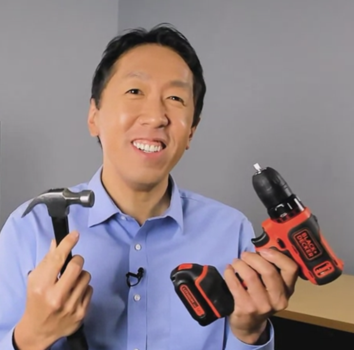

Please describe what is in this image?


In [20]:
# from utils import print_multimodal_prompt

print("-------Prompt--------")
print_multimodal_prompt(contents_image)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [21]:
# from utils import gemini_vision

gemini_vision(contents_image, model=multimodal_model)

' The image shows a man holding a hammer in one hand and a power drill in the other hand. He is smiling and looking at the camera. He is wearing a blue shirt and he has short black hair. The background is a grey wall.'

## Multimodality: Video + Text

- Load a video and a prompt.
- The video loads from a GCP bucket.

In [23]:
file_path = "dlai-sc-gemini-bucket/pixel8.mp4"
video_uri = f"gs://{file_path}"
video_url = f"https://storage.googleapis.com/{file_path}"

In [24]:
import IPython

In [25]:
IPython.display.Video(video_url, width=450)

In [26]:
prompt = """
Answer the following questions using the video only:
 - What is the main person's profession?
 - What are the main features of the phone highlighted?
 - Which city was this recorded in?
"""

In [30]:
video = Part.from_uri(video_uri, mime_type="video/mp4")
contents_video = [prompt, video]

**Note:** This cell is converted to markdown to prevent accidentally executing it. The cost to run this cell is approximately 0.12 USD (as of August 2024).

```Python
responses_4 = multimodal_model.generate_content(contents_video, stream=True)
```

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [32]:
for response in responses_4:
    print(response.text, end="")

 - The main person's profession is a photographer.
- The main features of the phone highlighted are the camera and the night mode.
- This was recorded in Tokyo, Japan.

## Gemini Model Parameters

- Load an image.
- You'll be using the [gemini-1.0-pro-vision-001](https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/gemini-pro-vision) model.
- First run the model using its _default parameters_.

In [33]:
image_1 = Image.load_from_file("./panda.png")

In [34]:
prompt_1 = """Write what is happening in the following image
from a unique perspective and do not mention names"""

In [35]:
contents = [image_1, prompt_1]

-------Prompt--------


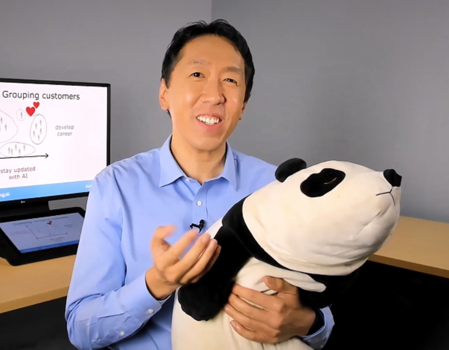

Write what is happening in the following image
from a unique perspective and do not mention names


In [36]:
# from utils import print_multimodal_prompt

print("-------Prompt--------")
print_multimodal_prompt(contents)

In [37]:
response_1 = multimodal_model.generate_content(
    contents,
    stream=True
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [38]:
for response in response_1:
    print(response.text, end="")

 A man is standing in front of a screen with a stuffed animal in his arms. He is smiling and looking at the camera. There is a slide on the screen that says "Grouping Customers". The man is wearing a blue shirt and black pants. He has short black hair and brown eyes. He is standing in an office space. There is a window in the background.

### Temperature, Top k

- GenerationConfig lets you set up the parameters for the model.

**Note:** In the latest version, `from vertexai.preview.generative_models` has been changed to `from vertexai.generative_models`.

`from vertexai.preview.generative_models` can still be used.

In [39]:
from vertexai.generative_models import GenerationConfig

In [40]:
# from utils import gemini_vision_parameters

- Setting `temperature=0.0` and `top_k=1`

In [41]:
generation_config_1 = GenerationConfig(
    temperature=0.0,
    top_k=1,
)

In [42]:
response_zero_temp = gemini_vision_parameters(
                        contents,
                        multimodal_model,
                        generation_config_1)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [43]:
print(response_zero_temp)

 A man is standing in front of a screen with a stuffed panda in his arms. He is smiling and looking at the camera. There is a slide on the screen that says "Grouping Customers". The man is wearing a blue shirt and black pants. He has short black hair and brown eyes. He is standing in an office. There is a window in the background.


In [44]:
responses_zero_temp = gemini_vision_parameters(
                        contents,
                        multimodal_model,
                        generation_config_1)

print(response_zero_temp)

 A man is standing in front of a screen with a stuffed panda in his arms. He is smiling and looking at the camera. There is a slide on the screen that says "Grouping Customers". The man is wearing a blue shirt and black pants. He has short black hair and brown eyes. He is standing in an office. There is a window in the background.


- Setting `temperature=1` and `top_k=40`

In [45]:
generation_config_2 = GenerationConfig(
    temperature=1,
    top_k=40,
)

In [46]:
responses_high_temp_topk = gemini_vision_parameters(
                            contents,
                            multimodal_model,
                            generation_config_2)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [47]:
print(responses_high_temp_topk)

 A man wearing a blue shirt is smiling and standing in front of a projector screen. There is a stuffed panda on his right side. Behind him, on a table, is a laptop. On the projector screen, there is a slide titled "Grouping Customers". The slide has a diagram of a career path with different options. On the left side of the slide, there are 4 hearts that represent customers with different needs. The man is using his hands to emphasize the different points on the slide.


### Top p

- Setting `top_p=0.01`, and maintaining `temperature=1`, `top_k=40`

In [48]:
generation_config_4 = GenerationConfig(
    temperature=1,
    top_k=40,
    top_p=0.01,
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [49]:
responses_high_temp_topp = gemini_vision_parameters(
                            contents,
                            multimodal_model,
                            generation_config_4)

print(responses_high_temp_topp)

 A man is standing in front of a screen with a stuffed panda in his arms. He is smiling and looking at the camera. There is a slide on the screen that says "Grouping Customers". The man is wearing a blue shirt and black pants. He has short black hair and brown eyes. He is standing in an office. There is a window in the background.


### Max Output Tokens

- The range for `max_output_tokens` is `1 (inclusive) to 2049 (exclusive)`
- When using `max_output_tokens`, the number of words returned by the model are 1 less than what you specify.
- So setting `max_output_tokens` to `1` will throw an error, since there would be no generated text.

In [50]:
generation_config_5 = GenerationConfig(
    max_output_tokens=10,
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [51]:
responses_max_output = gemini_vision_parameters(
                        contents,
                        multimodal_model,
                        generation_config_5)

print(responses_max_output)

 A man is standing in front of a screen


### Stop Sequences

- The range for `stop_sequences` is `1 (inclusive) to 17 (exclusive)`
- Multiple (no more than 16) words, numbers, space or special characters can be passed as a `list`.
- The model response stops _just before_ the _first time_ it encounters any stop sequence.

In [52]:
generation_config_6 = GenerationConfig(
    stop_sequences=["panda"]
)

**Note**: LLM's do not always produce the same results, especially because they are frequently updated. So the output you see in the video might be different than what you may get.

In [53]:
responses_stop = gemini_vision_parameters(
                    contents,
                    multimodal_model,
                    generation_config_6)

print(responses_stop)

 A man is standing in front of a projector screen giving a presentation on customer grouping. He is holding a stuffed 
